In [1]:
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


Looking in indexes: https://download.pytorch.org/whl/cu124


In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
device="cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_dir=r"archive (6)\Data\train"
test_dir=r"archive (6)/Data/test"

In [4]:
from torch.utils.data import dataloader
from torchvision import datasets,transforms

In [5]:
data_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()

])

In [6]:
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,transform=data_transform)


In [7]:
class_name=train_data.classes
class_name

['COVID19', 'NORMAL', 'PNEUMONIA']

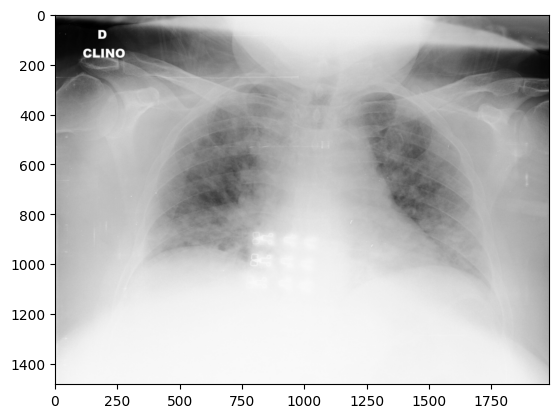

In [8]:
plt.imshow(Image.open(r"archive (6)\Data\train\COVID19\COVID19(1).jpg"))

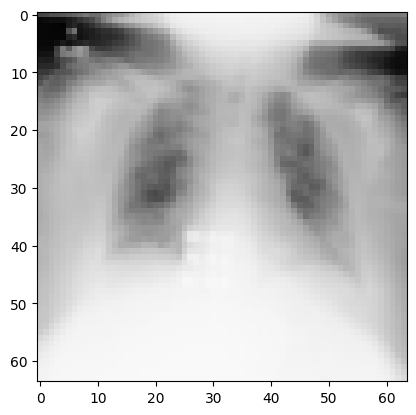

In [9]:
transformed_image=data_transform(Image.open(r"archive (6)\Data\train\COVID19\COVID19(1).jpg")).permute(1,2,0)
plt.imshow(transformed_image)

In [10]:
from torch.utils.data import DataLoader
train_dataloader=DataLoader(dataset=train_data,batch_size=32,num_workers=os.cpu_count(),shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=32,num_workers=os.cpu_count(),shuffle=False)
len(train_dataloader),len(test_dataloader)

(161, 41)

In [11]:
class Model(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,
                      kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*16*16, output_shape)
        )
    
    def forward(self, x):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.classifier(x)
        return x

In [12]:
model=Model(3,64,len(class_name))

In [13]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       36,928
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       36,928
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      49,155
Total params: 161,731
Trainable params: 161,731
Non-trainable params: 0

In [14]:

# ^ train set
def train_step(model,dataloader,loss_fn,optimizer):
    # print("train_step")
    model.train()
    train_loss,train_acc=0,0
    for batch,(X,y) in enumerate(dataloader):
        # print(bat/ch)
        X,y=X.to(device),y.to(device)
        # * Forward pass
        y_pred=model(X)
        # * Calculate loss
        loss=loss_fn(y_pred,y)
        train_loss+=loss.item()
        # * Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        #* Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    #* Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


# ^ test set

def test_step(model,dataloader,loss_fn):
    # print("test_step")
    model.eval()
    test_loss, test_acc=0,0
    with torch.inference_mode():
        # *loop
        for batch,(X,y) in enumerate(dataloader):
            # print(batch)
            X,y=X.to(device),y.to(device)
            # * Forward pass
            test_pred_logits=model(X)
            # * Calculate loss
            loss=loss_fn(test_pred_logits,y)
            test_loss+=loss.item()
            # * Calculate and accumulate accuracy metric across all batches
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    #* Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\ArnavBhatia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS=5

# * Create a new model

model.to(device)

# ~ Create optimizers and loss function

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# * Train and evaluate
from timeit import default_timer as timer
start_time=timer()
results_0 = train(model=model, 
              train_dataloader=train_dataloader, 
              test_dataloader=test_dataloader, 
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=NUM_EPOCHS)
end_time=timer()

print(f"Training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [03:02<12:09, 182.47s/it]

Epoch: 1 | train_loss: 0.4142 | train_acc: 0.8362 | test_loss: 0.2324 | test_acc: 0.9139


 40%|████      | 2/5 [06:02<09:03, 181.16s/it]

Epoch: 2 | train_loss: 0.2674 | train_acc: 0.9004 | test_loss: 0.1839 | test_acc: 0.9329


In [29]:
def plot_loss_curves(results):
    #* Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # * Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

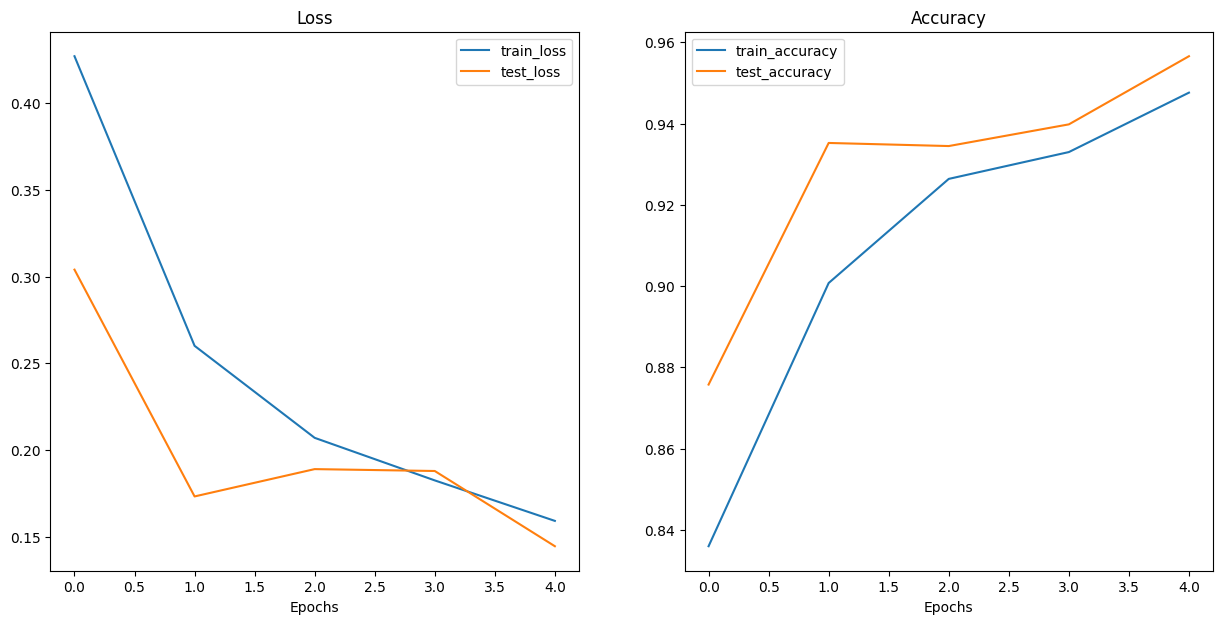

In [30]:
plot_loss_curves(results_0)


In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

2024-09-21 22:53:25.410742: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 22:53:25.550468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 22:53:25.623902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 22:53:25.643566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-21 22:53:25.727214: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


I0000 00:00:1726939408.642992    8678 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-21 22:53:28.644735: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


False